In [94]:
import requests
import pandas as pd
import platform
from isoweek import Week
print(platform.python_version())

3.9.4


In [313]:
# Source: https://www.ssb.no/statbank/table/07995/
# Vax: https://www.fhi.no/sv/vaksine/koronavaksinasjonsprogrammet/koronavaksinasjonsstatistikk/
POST_URL = "https://data.ssb.no/api/v0/en/table/07995"
payload = {
  "query": [
    {
      "code": "Kjonn",
      "selection": {
        "filter": "item",
        "values": [
          "0"
        ]
      }
    },
    {
      "code": "Alder",
      "selection": {
        "filter": "item",
        "values": [
          "999A",
          "000",
          "001",
          "002",
          "003",
          "004",
          "005",
          "006",
          "007",
          "008",
          "009",
          "010",
          "011",
          "012",
          "013",
          "014",
          "015",
          "016",
          "017",
          "018",
          "019",
          "020",
          "021",
          "022",
          "023",
          "024",
          "025",
          "026",
          "027",
          "028",
          "029",
          "030",
          "031",
          "032",
          "033",
          "034",
          "035",
          "036",
          "037",
          "038",
          "039",
          "040",
          "041",
          "042",
          "043",
          "044",
          "045",
          "046",
          "047",
          "048",
          "049",
          "050",
          "051",
          "052",
          "053",
          "054",
          "055",
          "056",
          "057",
          "058",
          "059",
          "060",
          "061",
          "062",
          "063",
          "064",
          "065",
          "066",
          "067",
          "068",
          "069",
          "070",
          "071",
          "072",
          "073",
          "074",
          "075",
          "076",
          "077",
          "078",
          "079",
          "080",
          "081",
          "082",
          "083",
          "084",
          "085",
          "086",
          "087",
          "088",
          "089",
          "090",
          "091",
          "092",
          "093",
          "094",
          "095",
          "096",
          "097",
          "098",
          "099",
          "100",
          "101",
          "102",
          "103",
          "104",
          "105+"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2012",
          "2013",
          "2014",
          "2015",
          "2016",
          "2017",
          "2018",
          "2019",
          "2020",
          "2021",
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

In [317]:
# Post spørring og få Pandas dataframe i retur
# benytter biblioteket pyjstat for JSON-stat

from pyjstat import pyjstat
import requests

resultat = requests.post(POST_URL, json = payload)
# Resultat gir bare http statuskode - 200 hvis OK. Body ligger i resultat.text
print(resultat)

dataset = pyjstat.Dataset.read(resultat.text)
raw = dataset.write('dataframe')
raw.head()

<Response [200]>


,sex,age,week,contents,year,value
0,Both sexes,All ages,Week 1,Deaths,2012,895.0
1,Both sexes,All ages,Week 1,Deaths,2013,1004.0
2,Both sexes,All ages,Week 1,Deaths,2014,781.0
3,Both sexes,All ages,Week 1,Deaths,2015,937.0
4,Both sexes,All ages,Week 1,Deaths,2016,870.0


In [398]:
df = raw.copy()
df["week_str"] = df.week.str.extract(r'(\d+)')
df["week_str"] = df["week_str"].apply(lambda x: "-W" + x.zfill(2) + "-1")
df['date'] = df[['year', 'week_str']].agg(''.join, axis=1)
df['date'] = pd.to_datetime(df['date'], format="%Y-W%U-%w")
df.age = df.age.str.extract(r"(\d+)").replace(np.nan,-1).astype(int)
df.index = df.date
df = df[~df.isna()]

In [399]:
grouped = df.groupby([pd.cut(df["age"], np.array([0,21,42,63,106]), labels=["0-21","21-42","43-63", "64+"]), df.index]).sum()
grouped = grouped.unstack(level=0)["value"]
grouped = grouped[(grouped != 0.)["64+"]]

<AxesSubplot:xlabel='date'>

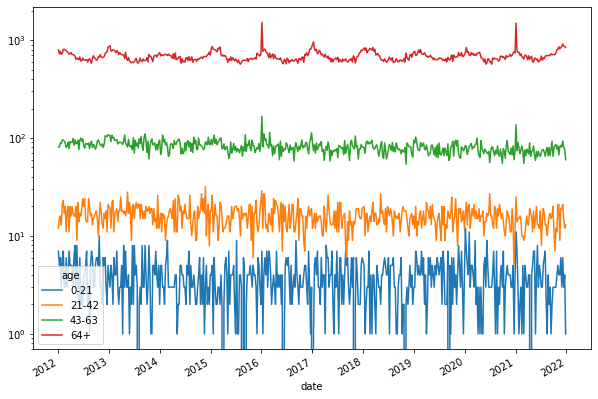

In [400]:
import matplotlib.pylab as plt
grouped.plot(figsize=(10,7), logy=True)

In [401]:
pre_2020_median = grouped["64+"][:"2019"].groupby(grouped["64+"][:"2019"].index.strftime("%W").astype(int)).median()
pre_2020_sd = grouped["64+"][:"2019"].groupby(grouped["64+"][:"2019"].index.strftime("%W").astype(int)).std()

In [402]:
pre_2020_median.name = "64+_median"
pre_2020_sd.name = "64+_std"
pre_2020 = pd.concat([pre_2020_median, pre_2020_sd], axis=1)
pre_2020.head()

,64+_median,64+_std
date,,
1,815.0,277.820943
2,770.5,89.036008
3,782.0,45.301372
4,785.5,48.559058
5,776.5,32.310713


In [403]:
week_df = pd.DataFrame(index=grouped.index, data = {"week": grouped.index.strftime("%W").astype(int)})
age_deaths = grouped.merge(week_df, left_index=True, right_index=True)
age_deaths = age_deaths.merge(pre_2020, left_on="week", right_index=True)
age_deaths.sort_index(inplace=True)
age_deaths.head()

,0-21,21-42,43-63,64+,week,64+_median,64+_std
date,,,,,,,
2012-01-02,7.0,12.0,81.0,794.0,1,815.0,277.820943
2012-01-09,5.0,15.0,81.0,721.0,2,770.5,89.036008
2012-01-16,6.0,16.0,89.0,765.0,3,782.0,45.301372
2012-01-23,3.0,13.0,88.0,716.0,4,785.5,48.559058
2012-01-30,6.0,21.0,96.0,735.0,5,776.5,32.310713


In [404]:
age_deaths["64+_centered"] =  age_deaths["64+"] - age_deaths["64+_median"]
age_deaths.head()

,0-21,21-42,43-63,64+,week,64+_median,64+_std,64+_centered
date,,,,,,,,
2012-01-02,7.0,12.0,81.0,794.0,1,815.0,277.820943,-21.0
2012-01-09,5.0,15.0,81.0,721.0,2,770.5,89.036008,-49.5
2012-01-16,6.0,16.0,89.0,765.0,3,782.0,45.301372,-17.0
2012-01-23,3.0,13.0,88.0,716.0,4,785.5,48.559058,-69.5
2012-01-30,6.0,21.0,96.0,735.0,5,776.5,32.310713,-41.5


Text(0.5, 0, 'Date')

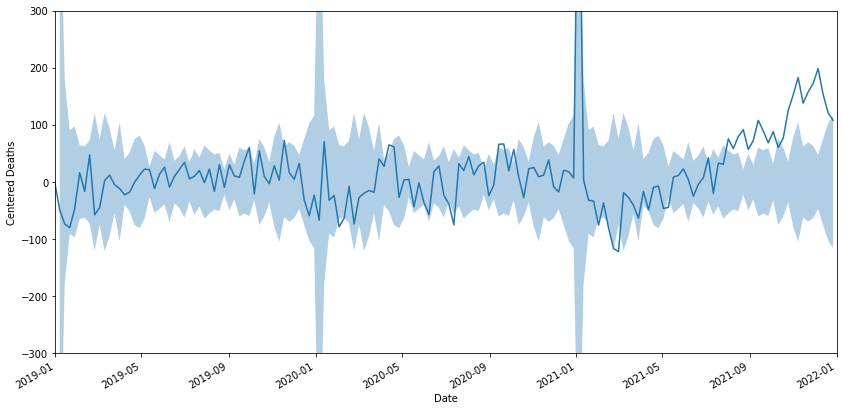

In [405]:
ax = age_deaths["64+_centered"].plot(figsize=(14,7))
ax.fill_between(age_deaths.index, - 2 * age_deaths["64+_std"], 2 * age_deaths["64+_std"], alpha=0.35)
plt.ylim([-300,300])
plt.xlim(["2019", "2022"])
plt.ylabel("Centered Deaths")
plt.xlabel("Date")

In [406]:
vax = pd.read_csv("../data/antall-personer-vaksiner.csv")
vax.head()

,Tid/Dato,Kumulativt antall personer vaksinert med 1.dose,Kumulativt antall personer vaksinert med 2.dose,Kumulativt antall personer vaksinert med 3.dose,Antall personer vaksinert med 1.dose,Antall personer vaksinert med 2.dose,Antall personer vaksinert med 3.dose
0,2020-12-02 00:00:00,0,0,0,0,0,0
1,2020-12-03 00:00:00,0,0,0,0,0,0
2,2020-12-04 00:00:00,0,0,0,0,0,0
3,2020-12-05 00:00:00,0,0,0,0,0,0
4,2020-12-06 00:00:00,0,0,0,0,0,0


In [407]:
vax.index = pd.to_datetime(vax.iloc[:, 0])
vax = vax.iloc[:, 1:]

In [438]:

week_vax = pd.concat([vax.groupby(pd.Grouper(freq="W-MON")).max().iloc[:, :3], vax.groupby(pd.Grouper(freq="W-MON")).sum().iloc[:, 3:]], axis=1)
week_vax.columns = ["dose1_cum", "dose2_cum", "dose3_cum", "1st Dose", "2st Dose", "3st Dose"]
week_vax.head()

,dose1_cum,dose2_cum,dose3_cum,1st Dose,2st Dose,3st Dose
Tid/Dato,,,,,,
2020-12-07,0,0,0,0,0,0
2020-12-14,0,0,0,0,0,0
2020-12-21,54,0,0,54,0,0
2020-12-28,749,0,0,695,0,0
2021-01-04,2516,0,0,1767,0,0


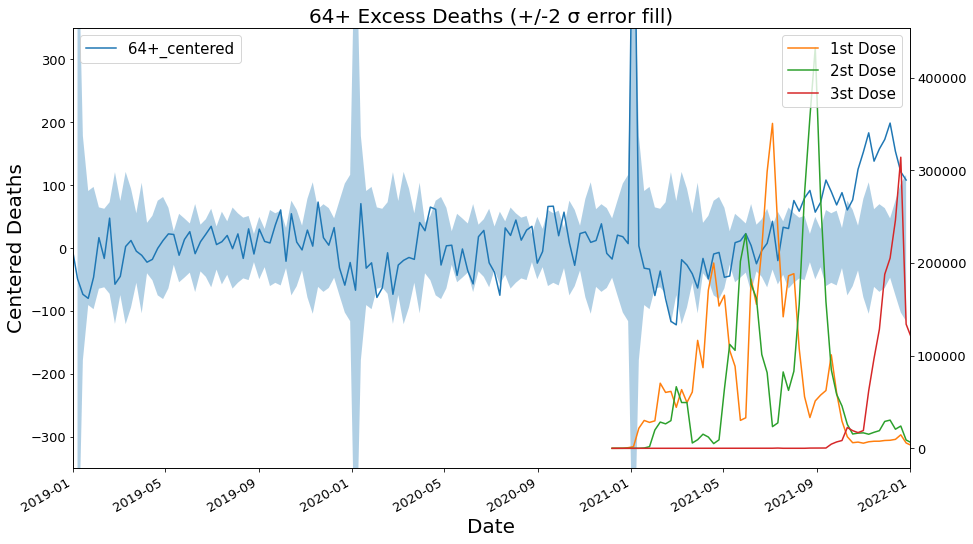

In [450]:

plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=13) #fontsize of the x tick labels
plt.rc('ytick', labelsize=13) #fontsize of the y tick labels
plt.rc('legend', fontsize=15) #fontsize of the legend

# Plot deaths among 64+ category with respect to deaths
death_vax = age_deaths.merge(week_vax, left_index=True, right_index=True, how="outer")
ax = death_vax["64+_centered"].plot(figsize=(15,9))
ax.fill_between(death_vax.index, - 2 * death_vax["64+_std"], 2 * death_vax["64+_std"], alpha=0.35)
plt.ylim([-350,350])
plt.xlim(["2019", "2022"])
plt.ylabel("Centered Deaths")
plt.xlabel("Date")
death_vax.loc[:, ["1st Dose"]].plot(ax=ax, secondary_y=True, legend=False, label="1st Dose")
death_vax.loc[:, ["2st Dose"]].plot(ax=ax, secondary_y=True, legend=False, label="2st Dose")
death_vax.loc[:, ["3st Dose"]].plot(ax=ax, secondary_y=True, legend=False, label="3st Dose")
first_legend = plt.legend(handles=[ax.lines[0]], loc='upper left')
plt.gca().add_artist(first_legend)
plt.legend(handles=ax.right_ax.lines, loc='upper right')
plt.title("64+ Excess Deaths (+/-2 σ error fill)")
plt.savefig("../figures/norway_deaths_vax.pdf")